In this notebook, an exploratory analysis of shadowgram processing algorithms will be tried out to see what is the best approach.

# Import image
First, pick a capture image from a Foucault test on a concave telescope mirror and show it.

In [1]:
import cv2

# Load our input image
#capture = cv2.imread('./Datasets/(165) 13_06_2019/1/Image_0.0.png')
#capture = cv2.imread('./Datasets/(165) 13_06_2019/1/Image_1.0.png')
capture = cv2.imread('./Datasets/(165) 13_06_2019/1/Image_2.0.png')

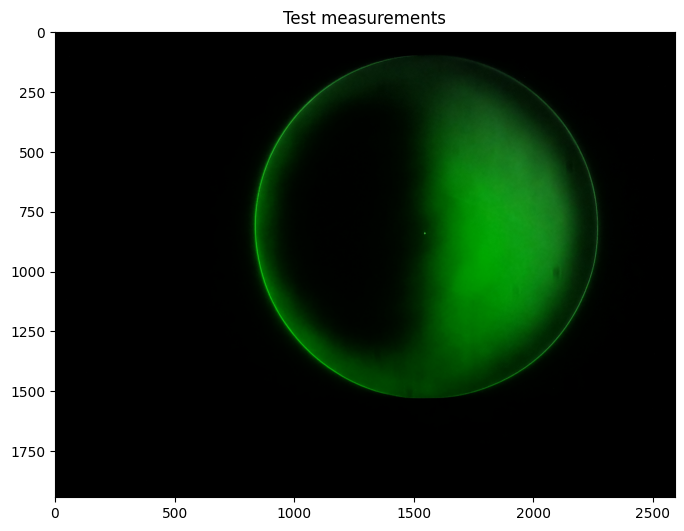

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture, cmap='gray')
  
# display that image
plt.show()

# Convert captured image to grayscale

In [3]:
# convert color image into grayscale image
capture_gray = cv2.cvtColor(capture, cv2.COLOR_RGB2GRAY)

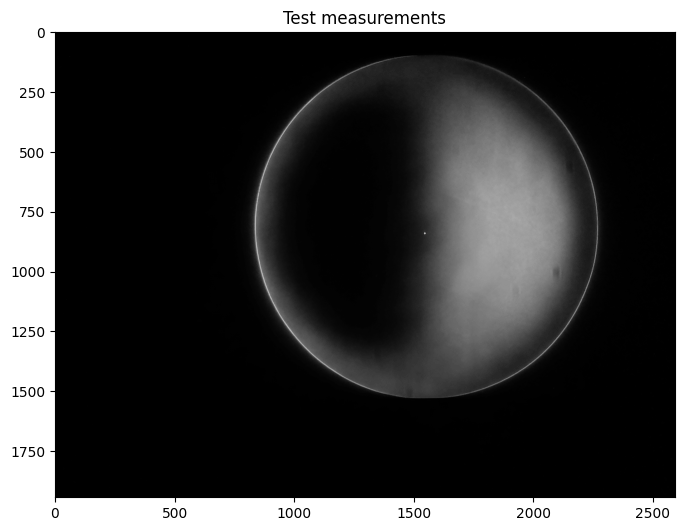

In [4]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_gray, cmap='gray')
  
# display that image
plt.show()

# Perform Canny edge detection algorithm on the grayscale image

In [5]:
#capture_gray_blur = cv2.blur(capture_gray, (3,3))
capture_gray_blur = cv2.bilateralFilter(capture_gray, 6, 6 * 2, 6 / 2)

canny_threshold = 40
capture_canny = cv2.Canny(capture_gray_blur, canny_threshold, canny_threshold*2, L2gradient=True)

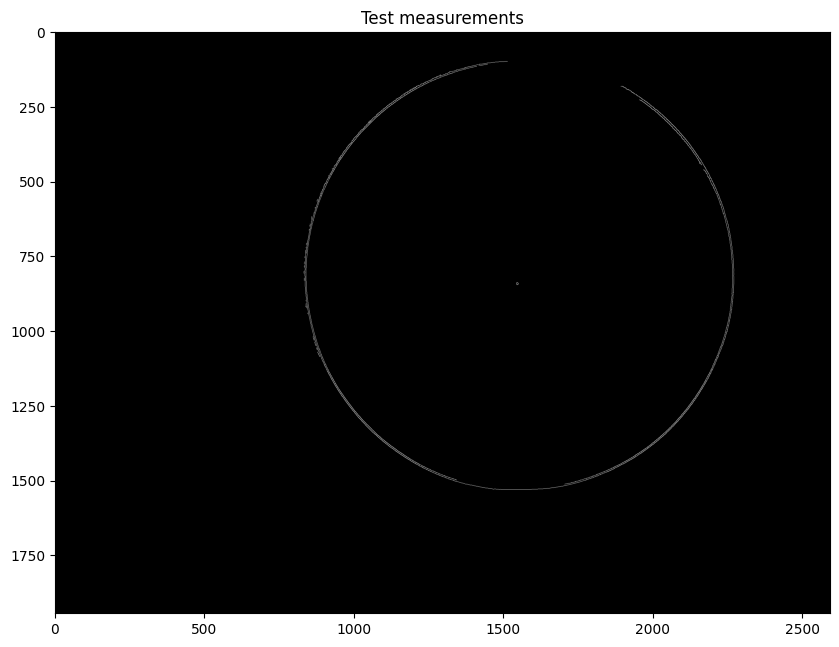

In [6]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_canny, cmap='gray')
  
# display that image
plt.show()

# Fit a circle to the (expected round) edge

In [7]:
import numpy as np

circles = cv2.HoughCircles(capture_gray, cv2.HOUGH_GRADIENT_ALT,
                           1.5, 800, param1=500, param2=0.9, minRadius=400, maxRadius=1500)

circles = np.uint16(np.around(circles))
circles = circles[0, 0]

if np.any(circles) != True:
  raise Exception("HoughCircles found no circles.")
    
line_thickness = 1
color_circle = (255, 0, 0)
center = (circles[0], circles[1])
radius = circles[2]
capture_circle = np.copy(capture)
capture_circle = cv2.circle(capture_circle, center, radius-30, color_circle, line_thickness, cv2.LINE_AA)
capture_circle = cv2.circle(capture_circle, center, radius+30, color_circle, line_thickness, cv2.LINE_AA)

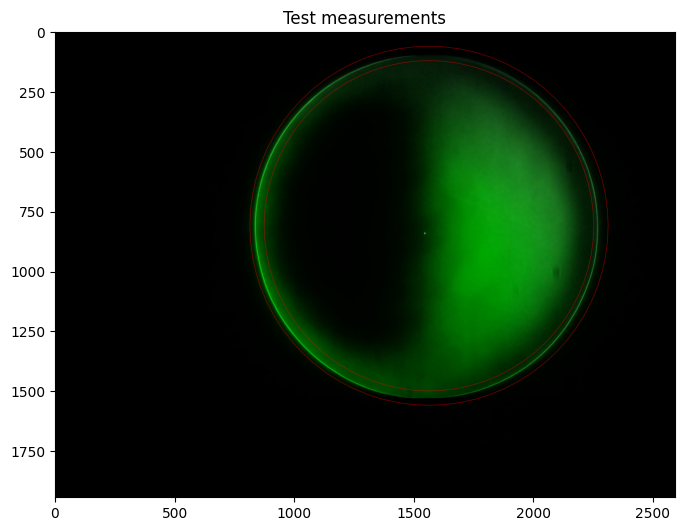

In [8]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_circle , cmap='gray')
#plt.imshow(capture_circles_center, cmap='gray')
  
# display that image
plt.show()

# Fit an ellipse to the (expected round) edge and crop image to it

In [9]:
capture_canny_points = cv2.findNonZero(capture_canny)

ellipse = cv2.fitEllipse(capture_canny_points)
#ellipse = cv2.fitEllipseAMS(capture_canny_points)
#ellipse = cv2.fitEllipseDirect(capture_canny_points)

line_thickness = 1
color_ellipse = (255, 0, 0)
capture_ellipse = np.copy(capture)
capture_ellipse = cv2.ellipse(capture_ellipse, ellipse, color_ellipse, line_thickness, cv2.LINE_AA)

#x, y, w, h = cv2.boundingRect(capture_canny_points)

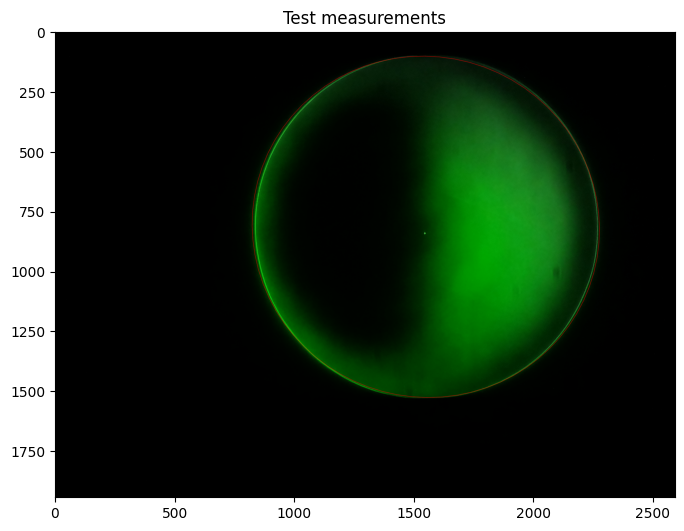

In [10]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_ellipse, cmap='gray')
#plt.imshow(capture_circles_center, cmap='gray')
  
# display that image
plt.show()

# TBD histogram

In [11]:
capture_gray_hist_mask = np.full_like(capture_gray, 0)
capture_gray_hist_mask = cv2.ellipse(capture_gray_hist_mask, ellipse, color_ellipse, -1, cv2.LINE_AA)

capture_gray_hist = cv2.calcHist([capture_gray], [0], capture_gray_hist_mask, [256], [0,256])

print(np.median(capture_gray_hist))

75.0


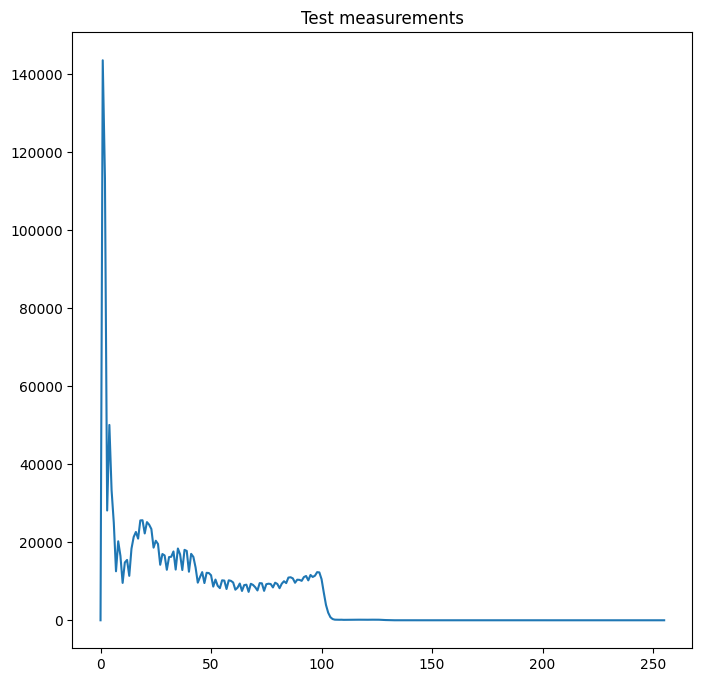

In [12]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.plot(capture_gray_hist)
  
# display that image
plt.show()

# TBD segment image

In [13]:
threshold = 32
_, capture_thresh = cv2.threshold(capture_gray_blur, threshold, 255, cv2.THRESH_BINARY)

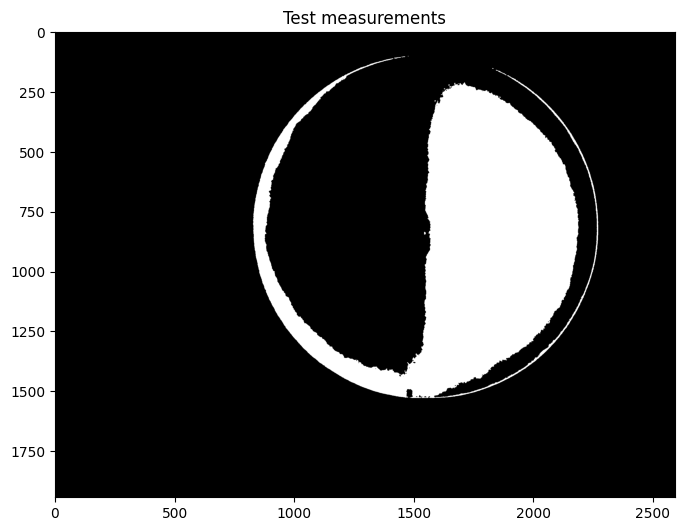

In [14]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_thresh, cmap='gray')
  
# display that image
plt.show()